<a href="https://colab.research.google.com/github/quinbez/Image_Classification_Using_Vision_Transformer/blob/main/Train_Using_Pretrained_Model_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

# specify the dataset url
dataset_url = "https://www.kaggle.com/datasets/sauravagarwal/flower-classification"
# download the dataset
od.download(dataset_url , ".")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: quinbez
Your Kaggle Key: ··········


100%|██████████| 219M/219M [00:01<00:00, 131MB/s]


In [ ]:
class_names = ["daisy", "dandelion","roses", "sunflowers", "tulips"]

In [ ]:
def set_seeds(seed: int = 42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seeds()

pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model = pretrained_vit,
        input_size = (32, 3, 224, 224),     # (batch_size, color_channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
train_dir = "flower-classification/flowers/flowers/flower_photos/train"
test_dir = "flower-classification/flowers/flowers/flower_photos/test"

In [ ]:
pretrained_vit_transform = pretrained_vit_weights.transforms()
print(pretrained_vit_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers:int = NUM_WORKERS):
  # Use ImageFolder to create datasets
  train_data = datasets.ImageFolder(train_dir, transform = transform)
  test_data = datasets.ImageFolder(test_dir, transform = transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

  return train_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir = train_dir,
                                                                                          test_dir = test_dir, transform = pretrained_vit_transform,
                                                                                          batch_size = 32)


In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size:int = 16, embedding_dim: int = 768):
    super().__init__()

    # Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels, out_channels = embedding_dim, kernel_size = patch_size, stride = patch_size, padding = 0)
    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input size must be divisible by patch size, image_shape: {image_resolution}, patch_size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim:int = 768, num_heads:int = 12, attn_dropout: float = 0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim, num_heads = num_heads, dropout = attn_dropout, batch_first = True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)

    return attn_output

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int = 768, mlp_size:int =  3076, dropout: float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    # Creating the Multilayer perceptron (MLP) layer
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dim),
        nn.Dropout( p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
               num_heads: int = 12,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1,     # Amount of dropout for dense layers from Table 3 for ViT-Base
               attn_dropout: float = 0 ):    # Amount of dropout for attention layers
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim, num_heads = num_heads, attn_dropout = attn_dropout)
    self.MLPBlock = MLPBlock(embedding_dim = embedding_dim, mlp_size = mlp_size, dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x     # Create residual connection for MSA block (add the input to the output)
    x = self.MLPBlock(x) + x      # Create residual connection for MLP block (add the input to the output)

    return x

In [ ]:
class  ViT(nn.Module):
  def __init__(self, img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000):
     super().__init__()
     assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

     # Calculate number of patches (height * width/patch^2)
     self.num_patches = (img_size * img_size) // patch_size**2
     self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
     self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
     self.embedding_dropout = nn.Dropout(p=embedding_dropout)
     self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

     self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
         embedding_dim = embedding_dim,
         num_heads = num_heads,
         mlp_size = mlp_size,
         mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])

     self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])

    return x


In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

vit = ViT(num_classes = len(class_names))

def train_steps(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float,float]:

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):

      X,y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

    return test_loss, test_acc

In [28]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  model.to(device)
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_steps(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                        device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [26]:
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(), lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = train(model = pretrained_vit,
                               train_dataloader = train_dataloader_pretrained,
                               test_dataloader = test_dataloader_pretrained,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 10,
                               device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5286 | train_acc: 0.8320 | test_loss: 0.4773 | test_acc: 0.8663
Epoch: 2 | train_loss: 0.2482 | train_acc: 0.9278 | test_loss: 0.4523 | test_acc: 0.8819
Epoch: 3 | train_loss: 0.1910 | train_acc: 0.9475 | test_loss: 0.4352 | test_acc: 0.8819
Epoch: 4 | train_loss: 0.1580 | train_acc: 0.9600 | test_loss: 0.4579 | test_acc: 0.8976
Epoch: 5 | train_loss: 0.1354 | train_acc: 0.9644 | test_loss: 0.4466 | test_acc: 0.8819
Epoch: 6 | train_loss: 0.1185 | train_acc: 0.9710 | test_loss: 0.4455 | test_acc: 0.8976
Epoch: 7 | train_loss: 0.1054 | train_acc: 0.9761 | test_loss: 0.4622 | test_acc: 0.9132
Epoch: 8 | train_loss: 0.0948 | train_acc: 0.9778 | test_loss: 0.4688 | test_acc: 0.9132
Epoch: 9 | train_loss: 0.0848 | train_acc: 0.9820 | test_loss: 0.4682 | test_acc: 0.9132
Epoch: 10 | train_loss: 0.0765 | train_acc: 0.9840 | test_loss: 0.4762 | test_acc: 0.9132


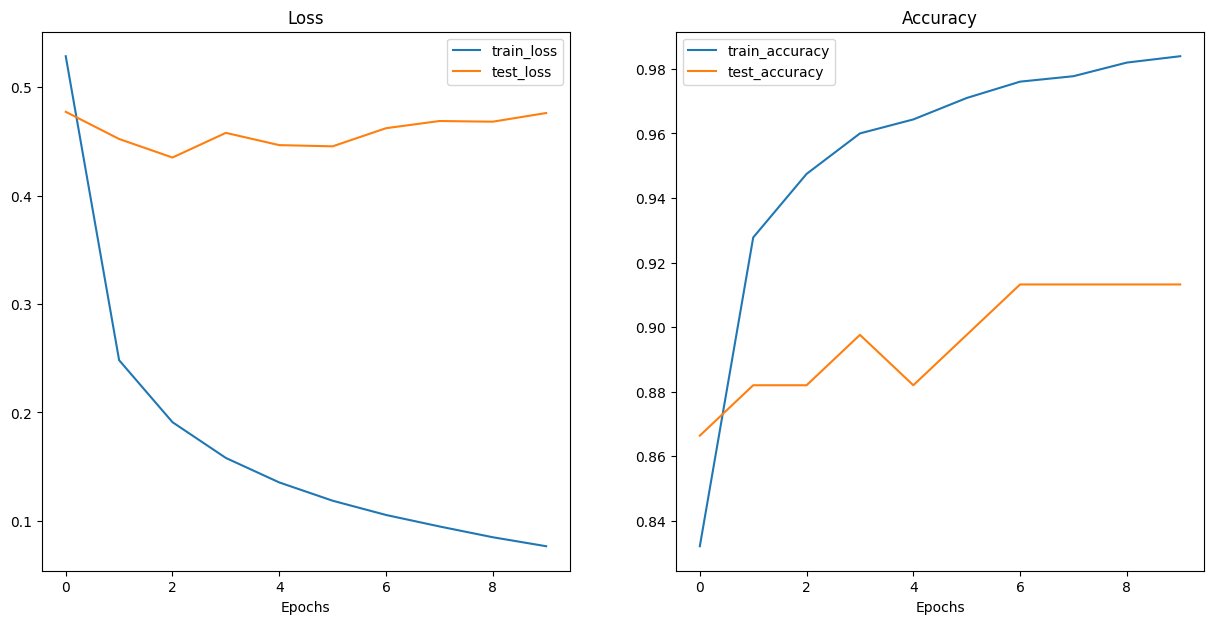

In [30]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (15,7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(pretrained_vit_results)

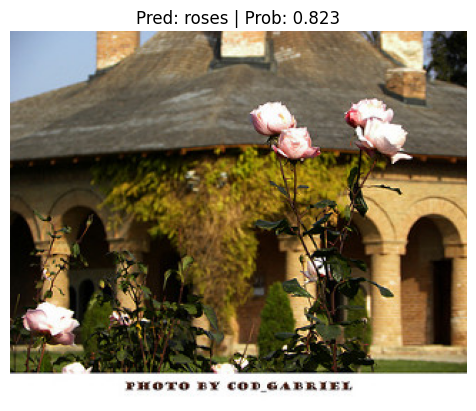

In [31]:
from PIL import Image

def pred_and_plot_image(
   model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",):

  img = Image.open(image_path)

  if transform:
    image_transform = transform
  else:
    image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim = 0)

    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  plt.figure()
  plt.imshow(img)
  plt.title(
      f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
  )
  plt.axis(False)

custom_image_path = "/content/flower-classification/flowers/flowers/flower_photos/test/roses/5181899042_0a6ffe0c8a_n.jpg"
pred_and_plot_image(model = pretrained_vit,
                image_path = custom_image_path,
                class_names = class_names)

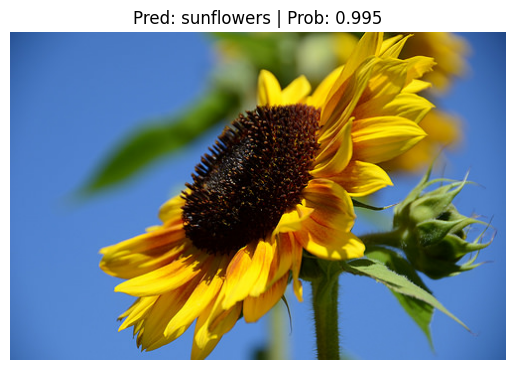

In [32]:
custom_image_path = "/content/flower-classification/flowers/flowers/flower_photos/test/sunflowers/20344366953_44fb51051b.jpg"
pred_and_plot_image(model = pretrained_vit,
                    image_path = custom_image_path,
                    class_names = class_names)